# Elliptic Equation

**강좌**: *수치해석 프로젝트*

## Laplace Equation
Laplace Equation과 Poisson Equation은 Steady-state 상태를 해석하는데 많이 사용된다.

$$
\nabla^2 u = f.
$$

*참고* $f=0$ 이면 Laplace Equation, $f\neq0$ 이면 Poisson Equation 이다.

대표적인 예제가 공간에서 Heat Conduction에 의해 Steady State에 도달할 때 이다.

예를 들면, 윗면에 온도만 300도이고 나머지 면의 온도가 100도인 경우 최종적으로 2차원 공간 내 온도 분포는 Laplace Equation으로 구할 수 있다.

$[0,1]^2$ 공간에 대해 수식으로 표현하면 다음과 같다.

$$
-k (T_{xx} + T_{yy}) = 0\\
T(x,1) = 300, T(x, 0) = T(0, y) = T(1, y) = 100
$$

편의상 $k=1$ 로 생각한다.

### Finite Difference Method
이전 Unsteady Heat equation과 마찬가지로 각 방향별 편미분을 2차 정확도 Central Difference로 표현하면 다음과 같다.

$$
\frac {T_{i+1,j} -2 T_{i,j} +  T_{i-1,j}}{\Delta x^2}
+
+\frac {T_{i,j+1}^n -2 T_{i,j}^n +  T_{i,j-1}^n}{\Delta y^2}
=0
$$

$\Delta x = \Delta y = h$ 인 경우 다음과 같이 정리된다.

$$
T_{i+1,j} + T_{i,j+1} - 4 T_{i,j} + T_{i,j-1} + T_{i-1,j}
=0
$$

이를 Matrix 형태로 나타내면 다음과 같다.

$$
\left [
\begin{matrix}
-4 & 1 &   & 1 &   &   &   &   &
\\ 
 1 &-4 & 1 &   & 1 &   &   &   &
\\
   & 1 &-4 &   &   & 1 &   &   &
\\
 1 &   &   &-4 & 1 &   & 1 &   & 
\\
   & 1 &   & 1 &-4 & 1 &   & 1 & 
\\
   &   & 1 &   & 1 &-4 &   &   & 1
\\
   &   &   & 1 &   &   &-4 & 1 & 
\\
   &   &   &   & 1 &   & 1 &-4 & 1
\\
   &   &   &   &   & 1 &   & 1 &-4
\end{matrix}
\right ]
\left [
\begin{matrix}
T_{1,1} \\
T_{1,2} \\
T_{1,3} \\
T_{2,1} \\
T_{2,2} \\
T_{2,3} \\
T_{3,1} \\
T_{3,2} \\
T_{3,3} 
\end{matrix}
\right ]
=
\left [
\begin{matrix}
-T_{1,0} -T_{0,1} \\ -T_{0,2} \\ -T_{0,3} - T_{1,4} \\
-T_{2,0} \\ 0 \\ T_{2,4} \\
-T_{4,1} -T_{3,0} \\ -T_{4,1} \\ -T_{4,1} - T_{3,4}
\end{matrix}
\right ]
$$

단 한번에 역행렬을 구함으로 써 모든 점에서 온도를 구할 수 있다.

다만 공간 차분 점이 늘어날수록 역행렬을 계산하는 시간이 급격하게 늘어난다.

### 예제
Laplace 행렬을 구성한 후 Linear System을 해석하시오.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

import numpy as np

plt.style.use('ggplot')
plt.rcParams['figure.dpi'] = 150

In [2]:
# Laplace Operator
def laplace_op(n):
    """
    Laplace operator
    
    Parameters
    ----------
    n : integer
        size of system
        
    Returns
    -------
    a : matrix
        operator
    """
    a = np.zeros((n*n,n*n))
    
    for i in range(n):
        for j in range(n):
            if i == j:
                for l in range(n):
                    for k in range(n):
                        ii = n*i + l
                        jj = n*j + k
                        
                        if l == k:
                            a[ii, jj] = -4
                        elif abs(l-k) == 1:
                            a[ii, jj] = 1
            elif abs(i-j) == 1:
                for l in range(n):
                    for k in range(n):
                        ii = n*i + l
                        jj = n*j + k
                        
                        if l == k:
                            a[ii, jj] = 1
    return a

In [3]:
# Right array to reflect BC
def bc(n):
    x = np.zeros(n*n)
    
    for i in range(n):
        for j in range(n):
            if i == n-1:
                x[n*i + j] -= 300
            elif i == 0:
                x[n*i + j] -= 100
            if j == n-1:
                x[n*i + j] -= 100
            elif j == 0:
                x[n*i + j] -= 100
                
    return x

In [4]:
# Construct operator
n = 19
a = laplace_op(n)
x = bc(n)

In [5]:
# Solve
from scipy import linalg

tt = np.linalg.solve(a, x)

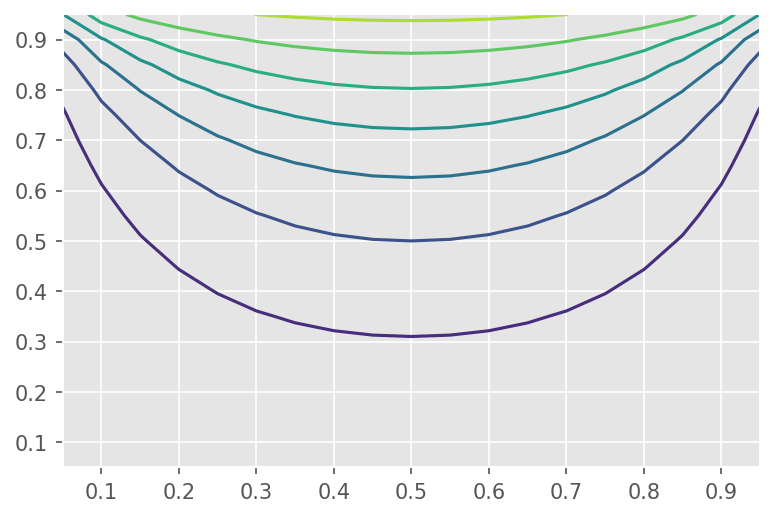

In [6]:
# Generate points (excluding BC)
xi = np.linspace(0, 1, n+2)
xx, yy = np.meshgrid(xi[1:-1], xi[1:-1])

# Plot contour
plt.contour(xx, yy, tt.reshape(n,n))

### Iterative Methods

#### 개념
매우 큰 행렬 System $Ax=b$ 를 반복해서 푸는 방법이다.

기본 개념은 다음과 같다.
- $A = A_1 - A_2$
   - $A_1$ 은 역행렬을 쉽게 구해지는 형태이다.
   
$$
A_1 x = A_2 x + b
$$
   
- 반복되는 해를 $x^{(k)}$ 하고 이를 적용한다.

$$
A_1 x^{(k+1)} = A_2 x^{(k)}+ b
$$

- $x^{(k)} \rightarrow x$ 이면 오차 $e^{(k)} = x^{(k+1)} - x^{(k)} \rightarrow 0$ 이다. 즉 오차가 $e^{(k)}$ 감소할 때 까지 반복한다.

   - 모든 경우에 오차가 감소하지 않는다. $A_1^{-1} A_2$ 의 Eigenvalue가 모두 1 보다 작아야 한다.
   
   
#### Point Jacobi Method
이 방법은 $A_1 = D$ 로 한 경우이다.

Laplace 문제에 적용하면 다음과 같이 표현할 수 있다.

$$
T_{i, j}^{(n+1)} = \frac{1}{4} \left (
T_{i+1,j}^{(n)} + T_{i,j+1}^{(n)} + T_{i,j-1}^{(n)} + T_{i-1,j}^{(n)}
\right )
$$

In [7]:
def jacobi(n, ti, dt):
    """
    Jacobi method
    
    Parameters
    ----------
    n : integer
        size
    ti : float
        current time
    dt : array
        difference
    """
    for i in range(1, n+1):
        for j in range(1, n+1):
            dt[i, j] = 0.25*(ti[i-1, j] + ti[i, j-1] + ti[i+1, j] + ti[i, j+1]) - ti[i, j]
            
def jacobi_v1(ti, dt):
    """
    Jacobi method (Vector version)
    
    Parameters
    ----------
    n : integer
        size
    ti : float
        current time
        
    Parameters
    -----------
    dt : array
        difference
    """
    dt[1:-1, 1:-1] = 0.25*(ti[:-2, 1:-1] + ti[1:-1, :-2] + ti[2:, 1:-1] + ti[1:-1, 2:]) - ti[1:-1, 1:-1]

In [8]:
n = 19
tol = 1e-5
ti = np.zeros((n+2, n+2))
dt = np.zeros((n+2, n+2))

def bc(t):
    t[-1, 1:-1] = 300
    t[0, 1:-1] = 100
    t[1:-1, -1] = 100
    t[1:-1, 0] = 100
            
err = 1
hist_jacobi = []
while err > tol:
    # Apply BC
    bc(ti)
    
    # Run Jacobi
    #jacobi(n, ti, dt)
    jacobi_v1(ti, dt)
    
    # Compute Error
    err = linalg.norm(dt) / n
    hist_jacobi.append(err)
    
    # Update solution
    ti += dt

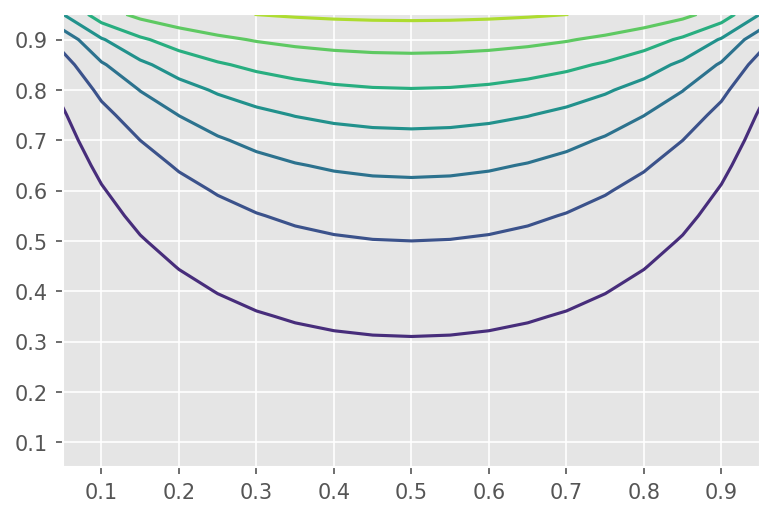

In [9]:
# Generate points (excluding BC)
xi = np.linspace(0, 1, n+2)
xx, yy = np.meshgrid(xi[1:-1], xi[1:-1])

# Plot contour
plt.contour(xx, yy, ti[1:-1, 1:-1])

#### Gauss-Seidel
$A=L+D+U$ 라 생각했을 때 $A_1 = L + D$인 방법이다.

Laplace 방정식에 적용하면 다음과 같다.

$$
T_{i, j}^{(n+1)} = \frac{1}{4} \left (
T_{i-1,j}^{(n+1)} + T_{i,j-1}^{(n+1)} + T_{i,j+1}^{(n)} + T_{i+1,j}^{(n)}
\right )
$$

In [10]:
def gauss_seidel(n, ti, dt):
    """
    Gauss-Seidel method
    
    Parameters
    ----------
    n : integer
        size
    ti : float
        current time
    dt : array
        difference
    """
    for i in range(1, n+1):
        for j in range(1, n+1):
            tij = ti[i, j]
            ti[i, j] = 0.25*(ti[i-1, j] + ti[i, j-1] + ti[i+1, j] + ti[i, j+1])
            dt[i, j] = ti[i, j] - tij

In [11]:
n = 19
tol = 1e-5
ti = np.zeros((n+2, n+2))
dt = np.zeros((n+2, n+2))

def bc(t):
    t[-1, 1:-1] = 300
    t[0, 1:-1] = 100
    t[1:-1, -1] = 100
    t[1:-1, 0] = 100
            
err = 1
hist_gs = []
while err > tol:
    # Apply BC
    bc(ti)
    
    # Run Gauss-Seidel
    gauss_seidel(n, ti, dt)
    
    # Compute Error
    err = linalg.norm(dt) / n
    hist_gs.append(err)

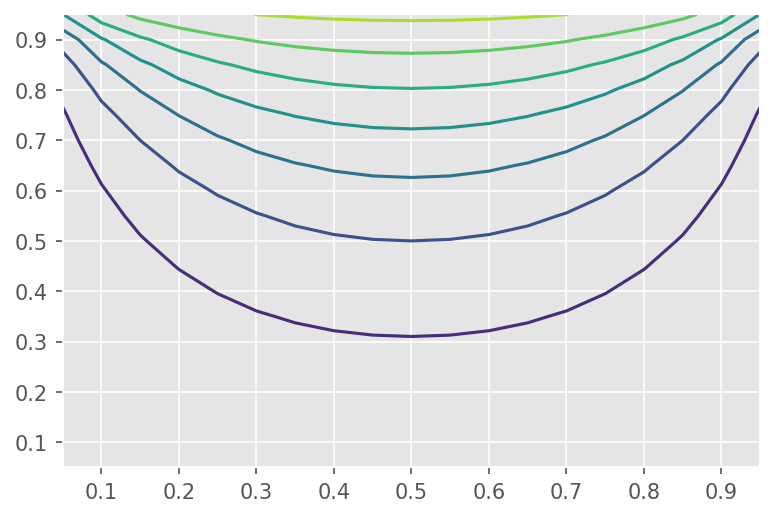

In [12]:
# Generate points (excluding BC)
xi = np.linspace(0, 1, n+2)
xx, yy = np.meshgrid(xi[1:-1], xi[1:-1])

# Plot contour
plt.contour(xx, yy, ti[1:-1, 1:-1])

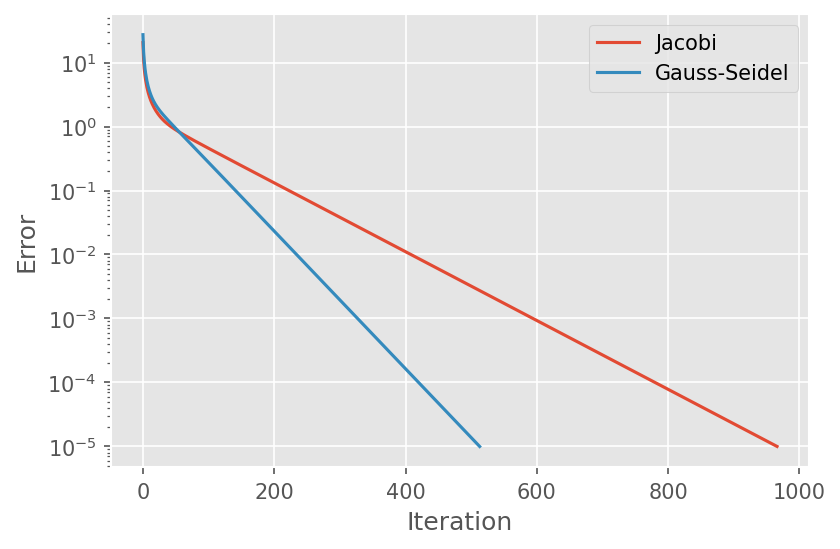

In [13]:
# Compute History
plt.semilogy(range(len(hist_jacobi)), hist_jacobi)
plt.semilogy(range(len(hist_gs)), hist_gs)
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.legend(['Jacobi', 'Gauss-Seidel'])